In [1]:
import re

import spacy
from spacy import displacy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [2]:
de = spacy.load('de_dep_news_trf')
el = spacy.load('el_core_news_lg')

In [3]:
MODELS = {
    'de': de,
    'el': el
}

COLORS = {
    'de': '#a52040',
    'el': '#404080',
    'err': '#b4b446'
}

In [4]:
texts = pd.read_csv('examples.csv', sep=',', encoding='utf-8')

with pd.option_context('display.max_colwidth', None):
    display(texts)

,id,lang,version,text
0,1,el,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173)
1,1,el,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις. (AK 173)
2,1,de,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften. (BGB § 133)
3,1,de,ελλΑΚ-1951,"Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht, ohne an den Worten zu haften."


In [5]:
def remove_crossrefs(text):
    """Remove cross references from text. 
    A cross reference is a string of the form (ΑΚ 123) or (BGB § 123)."""
    pattern = r'\((ΑΚ|AK|BGB)\s*§?\s*\d+\)'
    return re.sub(pattern, '', text)

In [6]:
texts['pos'] = texts['length'] = np.nan

for i, text in enumerate(texts['text'].to_list()):
    text = remove_crossrefs(text)
    doc = MODELS[texts['lang'][i]](text)
    texts.loc[i, 'length'] = len([token.text for token in doc 
                                  if not token.is_punct and not token.is_digit])
    texts.loc[i, 'pos'] = " ".join([token.pos_ for token in doc])
    displacy.render(doc, style='dep', jupyter=True)

texts['length'] = texts['length'].astype(int)

In [7]:
with pd.option_context('display.max_colwidth', None):
    display(texts)

,id,lang,version,text,pos,length
0,1,el,ελλΑΚ-1940,Κατὰ τὴν ἑρμηνείαν τῆς δηλώσεως βουλήσεως ἀναζητεῖται ἤ ἀληθὴς βούλησις ἄνευ προσηλώσεως εἱς τὰς λέξεις. (ΑΚ 173),ADP DET NOUN DET NOUN NOUN VERB PROPN ADV NOUN ADJ ADJ ADP DET NOUN PUNCT,15
1,1,el,ελλΑΚ-2023,Κατά την ερμηνεία της δήλωσης βουλήσεως αναζητείται η αληθινή βούληση χωρίς προσήλωση στις λέξεις. (AK 173),ADP DET NOUN DET NOUN NOUN VERB DET ADJ NOUN ADP NOUN ADP NOUN PUNCT,14
2,1,de,γερΑΚ-2023,Bei der Auslegung einer Willenserklärung ist der wirkliche Wille zu erforschen und nicht an dem buchstäblichen Sinne des Ausdrucks zu haften. (BGB § 133),ADP DET NOUN DET NOUN AUX DET ADJ NOUN PART VERB CCONJ PART ADP DET ADJ NOUN DET NOUN PART VERB PUNCT,21
3,1,de,ελλΑΚ-1951,"Bei der Auslegung einer Willenserklärung wird der wirkliche Wille erforscht, ohne an den Worten zu haften.",ADP DET NOUN DET NOUN AUX DET ADJ NOUN VERB PUNCT SCONJ ADP DET NOUN PART VERB PUNCT,16


In [8]:
grouped = texts.groupby(['id', 'lang']).agg({'length': ['mean', 'std']}).reset_index()
grouped

id lang length          
            mean       std
0  1   de   18.5  3.535534
1  1   el   14.5  0.707107

In [9]:
# Take the grouped data by id and lang. Then calculate how different the pos tags are in each language and plot the results.
grouped_ = texts.groupby(['id', 'lang']).agg({'pos': lambda x: x.value_counts().index[0]}).reset_index()
grouped_['pos'] = grouped_['pos'].str.split(' ')
grouped_['pos_diff'] = grouped_['pos'].apply(lambda x: len(set(x)) / len(x))
grouped_ = grouped_.drop(columns=['pos'])
grouped_

,id,lang,pos_diff
0,1,de,0.409091
1,1,el,0.500000


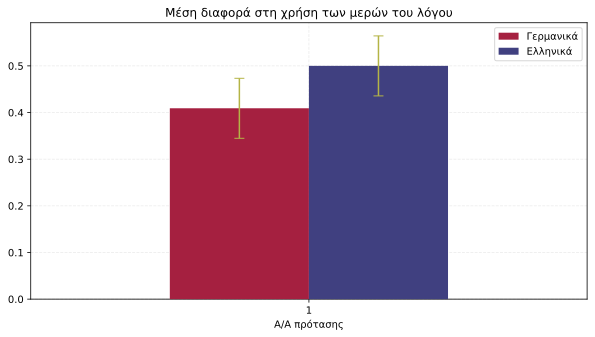

In [10]:
from matplotlib.lines import Line2D

(grouped_
    .groupby(['id', 'lang'])
    .agg({'pos_diff': 'mean'})
    .unstack()
    .plot(kind='bar', figsize=(10, 5), zorder=3, color=COLORS.values(),
          yerr=grouped_['pos_diff'].std(),
          error_kw={'capsize': 5, 'ecolor': COLORS['err']})
)
plt.legend(['Γερμανικά', 'Ελληνικά'])
plt.title('Μέση διαφορά στη χρήση των μερών του λόγου')
plt.xticks(rotation=0)
plt.xlabel('Α/Α πρότασης')
plt.grid(axis='both', alpha=0.25, linestyle='--', zorder=0)
plt.show();